In [1]:
!jupyter nbextension enable --py widgetsnbextension


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [99]:
import tensorflow as tf

import os
import math
import numpy as np
from tqdm.notebook import tqdm
from tensorflow import keras
from tensorflow.keras import layers
import rasterio
from cv2 import resize
import cv2
from rasterio.plot import reshape_as_raster, reshape_as_image
from tensorflow.keras.layers import Activation
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Add, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from IPython.display import display

lr_size = 64
hr_size = 128

def PSNRLoss(y_true, y_pred):

    max_pixel = 1.0
    return (10.0 * K.log((max_pixel ** 2) / (K.mean(K.square(y_pred - y_true), axis=-1)))) / 2.303

def make_srcnn():    
    srcnn = Sequential()
    srcnn.add(Conv2D(64,9,padding='same',input_shape=(128,128,1)))
    srcnn.add(Activation('relu'))
    srcnn.add(Conv2D(32,1,padding='same'))
    srcnn.add(Activation('relu'))
    srcnn.add(Conv2D(1,5,padding='same'))
    srcnn.compile(optimizer='adam', loss='mean_squared_error', metrics=[PSNRLoss])
    return srcnn

In [91]:
def load_data(hr_dir, lr_dir):
    hr_image_filenames = [os.path.join(hr_dir, x) for x in os.listdir(hr_dir) if x.endswith(".tif")]
    lr_image_filenames = [os.path.join(lr_dir, "lr_" + os.path.basename(x)) for x in hr_image_filenames]

    hr_images = []
    lr_images = []
    
    for index in tqdm(range(len(lr_image_filenames))):
        

        lr_image = rasterio.open(lr_image_filenames[index])
        hr_image = rasterio.open(hr_image_filenames[index])
                
        lr_images.append(cv2.cvtColor(resize(reshape_as_image(lr_image.read()), (hr_size, hr_size), interpolation = cv2.INTER_NEAREST), cv2.COLOR_BGR2YUV))
        hr_images.append(cv2.cvtColor(np.squeeze(reshape_as_image(hr_image.read())), cv2.COLOR_BGR2YUV))

    hr_out = []
    lr_out = []
    
    for i in range(len(hr_images)):
        y_hr, _, _ = cv2.split(hr_images[i])
        hr_out.append(y_hr)
        y_lr, _, _ = cv2.split(lr_images[i])

        lr_out.append(y_lr)
        

    return np.expand_dims(np.array(lr_images)/255, axis = -1), np.expand_dims(np.array(hr_images)/255, axis = -1), np.expand_dims(np.array(lr_out)/255, axis = -1),np.expand_dims( np.array(hr_out)/255, axis = -1)

In [92]:
from sklearn.model_selection import train_test_split

lr_tiles, hr_tiles, lr_data, hr_data = load_data("hr_tiles", "lr_tiles")

lr_train, lr_test, hr_train, hr_test = train_test_split(lr_data, hr_data, test_size=0.20, random_state=42)


  0%|          | 0/5290 [00:00<?, ?it/s]

In [96]:
class ESPCNCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super(ESPCNCallback, self).__init__()

    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []

    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * math.log10(1 / logs["loss"]))

In [97]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=10)
model_checkpoint =  ModelCheckpoint('sr_checkpoint.h5', save_best_only = True)


callbacks = [ESPCNCallback(), early_stopping_callback, model_checkpoint]

In [117]:
epochs = 100


srcnn = make_srcnn()

srcnn.fit(
    lr_train,hr_train,
    epochs=50,
    validation_data=(lr_test, hr_test),batch_size=5,callbacks=callbacks
)


Epoch 1/50
847/847 [==============================] - 4s 5ms/step - loss: 0.0315 - PSNRLoss: inf - val_loss: 0.0446 - val_PSNRLoss: 17.8024
Mean PSNR for epoch: 13.57
Epoch 2/50
847/847 [==============================] - 4s 5ms/step - loss: 0.0291 - PSNRLoss: inf - val_loss: 0.0288 - val_PSNRLoss: inf
Mean PSNR for epoch: 15.46
Epoch 3/50
847/847 [==============================] - 4s 5ms/step - loss: 0.0286 - PSNRLoss: inf - val_loss: 0.0325 - val_PSNRLoss: inf
Mean PSNR for epoch: 14.94
Epoch 4/50
847/847 [==============================] - 4s 5ms/step - loss: 0.0286 - PSNRLoss: inf - val_loss: 0.0284 - val_PSNRLoss: 20.1866
Mean PSNR for epoch: 15.52
Epoch 5/50
847/847 [==============================] - 4s 5ms/step - loss: 0.0284 - PSNRLoss: inf - val_loss: 0.0293 - val_PSNRLoss: inf
Mean PSNR for epoch: 15.39
Epoch 6/50
847/847 [==============================] - 4s 5ms/step - loss: 0.0283 - PSNRLoss: inf - val_loss: 0.0281 - val_PSNRLoss: inf
Mean PSNR for epoch: 15.57
Epoch 7/50
847

847/847 [==============================] - 4s 5ms/step - loss: 0.0280 - PSNRLoss: inf - val_loss: 0.0283 - val_PSNRLoss: 20.1797
Mean PSNR for epoch: 15.54


In [118]:
tf.keras.backend.clear_session()

srcnn = make_srcnn()
srcnn.load_weights('sr_checkpoint.h5')

In [120]:
from smooth_tiled_predictions import predict_img_with_smooth_windowing

tf.keras.backend.clear_session()

multiple = 4

lr_image = rasterio.open("lr_test2.tif")
lr_array = resize(reshape_as_image(lr_image.read()[:3,:,:]), (lr_image.width * multiple, lr_image.height * multiple), interpolation = cv2.INTER_AREA)

output= cv2.split(cv2.cvtColor(np.array(lr_array, dtype=np.uint8), cv2.COLOR_BGR2YUV))


array = np.expand_dims(output[0], axis = -1)
array.shape

(1904, 3964, 1)

In [122]:
sr_input = predict_img_with_smooth_windowing(
    array,
    window_size=128,
    subdivisions=2,  # Minimal amount of overlap for windowing. Must be an even number.
    nb_classes=1,
    pred_func=(
        lambda img_batch_subdiv: srcnn.predict((img_batch_subdiv))
    )
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:15<00:00,  1.99s/it]


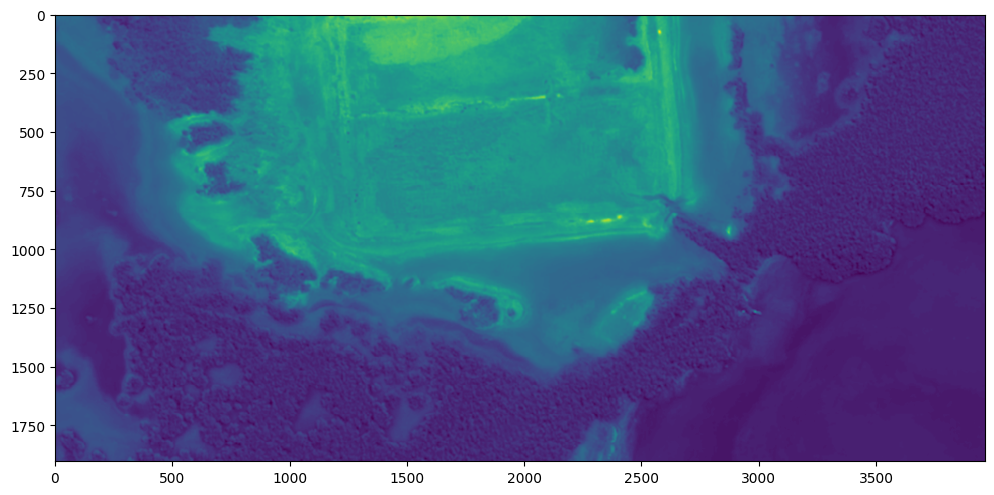

In [124]:

import matplotlib.pyplot as plt
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(array)


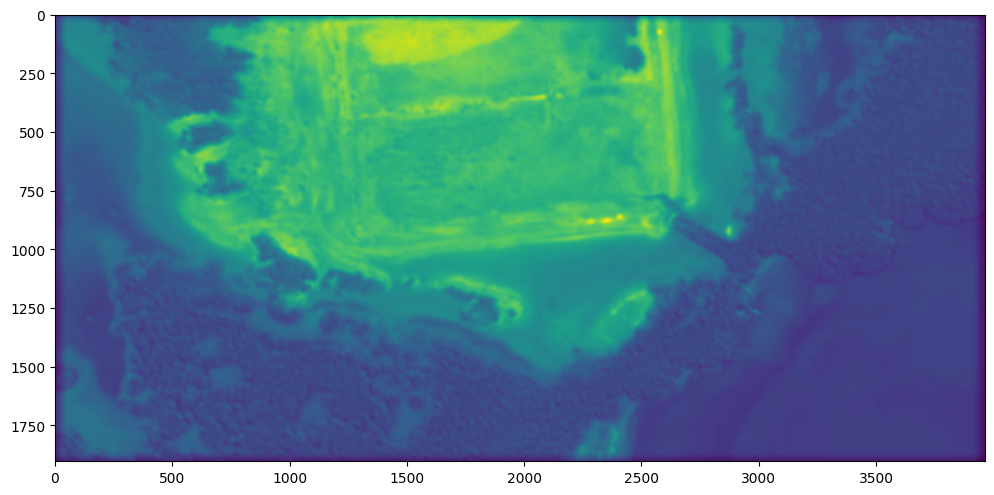

In [125]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(sr_input)

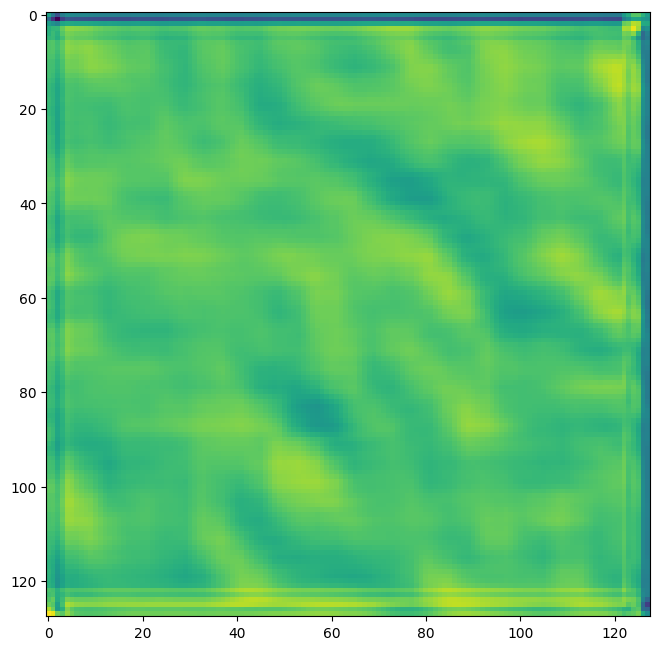

In [126]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
new_array = array[1250:1250+128, 500:500+128, :]
plt.imshow(np.squeeze(srcnn.predict(np.expand_dims(new_array, axis = 0))))

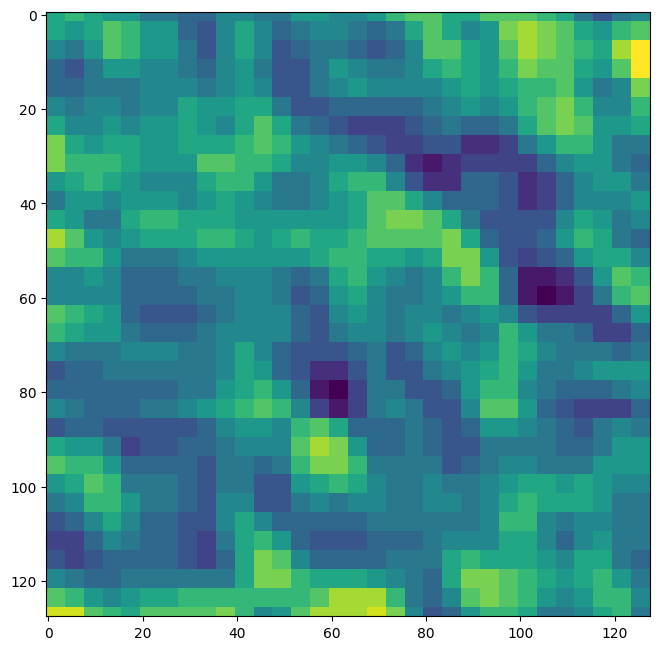

In [127]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')

plt.imshow(new_array)